In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

import itertools
import numpy as np
import choix
import math

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed


Text(0, 0.5, 'Number of pairwise comparisons')

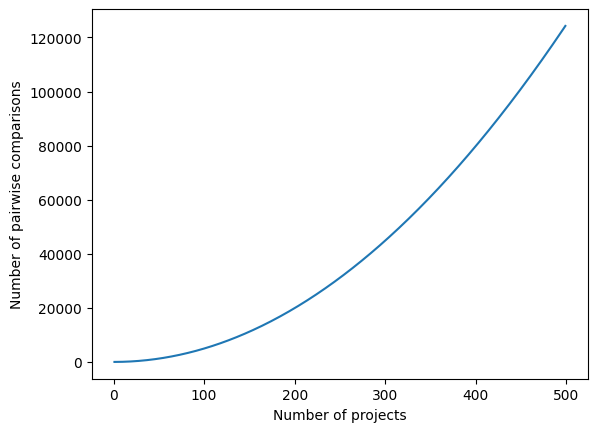

In [49]:
# show growth curve for how fast the number of pairs to compare grows
n_projects_vec = np.arange(1, 500)
ncombs = []
for n_projects in n_projects_vec:
    n_pairs = math.comb(n_projects, 2)
    ncombs.append(n_pairs)

plt.plot(n_projects_vec, ncombs)
plt.xlabel('Number of projects')
plt.ylabel('Number of pairwise comparisons')

In [50]:
# round design variables

# design the distribution of expertise for voters
# the approach here is to use the beta-distribution as a way to generate a distribution of expertise,
#  with several parameters mapping to low, medium, and high expertise
# We then draw from this distribution to assign expertise to each voter
expertise2params = {
    'very-low': (1, 6),
    'low': (1, 3),
    'medium': (3, 3),
    'high': (3, 1),
    'very-high': (6, 1),
    'const-0.5': (0.5,),
    'const-0.75': (0.75,),
    'const-1.0': (1.0,),
}

# similar to the above, define a distribution of project impact.
impact2params = {
    'low': (1, 4),
    'medium': (2, 2),
    'high': (4, 1),
    'random': (1, 1),
    'u-shaped': (0.5, 0.5)
}

laziness2params = {
    'low': (1, 3),
    'medium': (3, 3),
    'high': (3, 1),
    'const-0.0': (0.0,),
    'const-0.5': (0.5,),
    'const-0.75': (0.75,),
    'const-1.0': (1.0,),
}

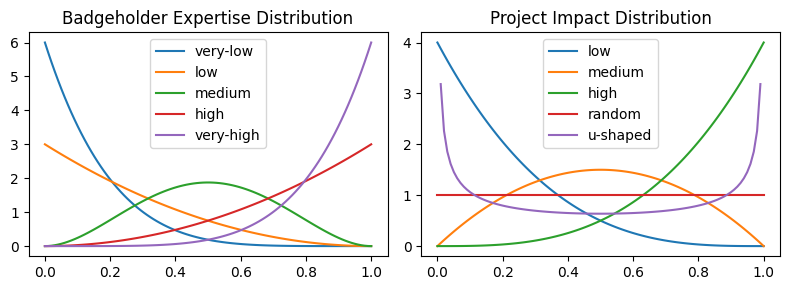

In [51]:
# lets plot the beta distributions pdfs to get a sense of what they look like
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
x = np.linspace(0, 1, 100)

for expertise, params in expertise2params.items():
    if 'const' in expertise:
        continue
    pdf = stats.beta.pdf(x, *params)
    ax[0].plot(x, pdf, label=expertise)
ax[0].legend()
ax[0].set_title('Badgeholder Expertise Distribution')

for impact, params in impact2params.items():
    pdf = stats.beta.pdf(x, *params)
    ax[1].plot(x, pdf, label=impact)
ax[1].legend()
ax[1].set_title('Project Impact Distribution')

plt.tight_layout()

/tmp/ipykernel_87723/199399753.py:11: RuntimeWarning: divide by zero encountered in divide
  th = 0.5 + project_impact_difference_vec*0.5/(1-e)
/tmp/ipykernel_87723/199399753.py:11: RuntimeWarning: invalid value encountered in divide
  th = 0.5 + project_impact_difference_vec*0.5/(1-e)


Text(0, 0.5, 'Probability of Voting \n for Correct Project (%)')

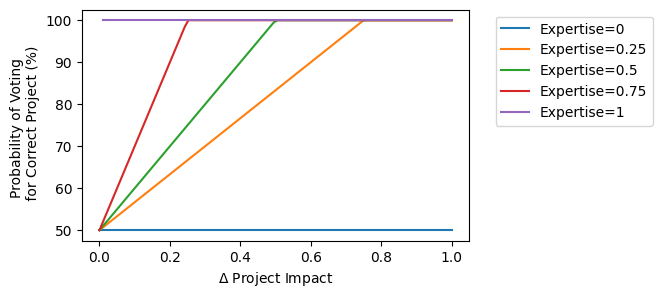

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

project_impact_difference_vec = np.linspace(0, 1, 100)
expertise = [0, 0.25, 0.5, 0.75, 1]

# plot the badgeholder expertise to voting mapping w/ linear trajectory
for e in expertise:
    if e == 0:
        th = 0.5 * np.ones_like(project_impact_difference_vec)
    else:
        th = 0.5 + project_impact_difference_vec*0.5/(1-e)
    th = np.clip(th, 0, 1)
    ax.plot(project_impact_difference_vec, th*100, label=f'Expertise={e}')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel(r'$\Delta$ Project Impact')
ax.set_ylabel('Probability of Voting \n for Correct Project (%)')

In [53]:
# a metric used for comparing the inferred ranking to the actual ranking
def min_swaps_to_sort(arr1, arr2):
    n = len(arr1)
    # Create a map of value to its index in arr1
    index_map = {value: i for i, value in enumerate(arr1)}

    visited = [False] * n
    swaps = 0

    for i in range(n):
        if visited[i] or arr1[i] == arr2[i]:
            continue

        cycle_size = 0
        x = i

        while not visited[x]:
            visited[x] = True
            x = index_map[arr2[x]]
            cycle_size += 1

        if cycle_size > 0:
            swaps += (cycle_size - 1)

    return swaps

def run_single_simulation(
        n_badgeholders=50, 
        badgeholder_expertise_distribution='medium',
        badgeholder_voting_style='skewed_towards_impact',
        badgeholder_laziness_distribution='const-0.0',
        n_projects=20, 
        project_impact_distribution='low',
        random_seed=1234
    ):
    rng = np.random.default_rng(random_seed)

    # create badgeholders
    badgeholder_list = []
    for ii in range(n_badgeholders):
        badgeholder_id = ii
        if 'const' in badgeholder_expertise_distribution:
            expertise = expertise2params[badgeholder_expertise_distribution][0]
        else:
            expertise = rng.beta(*expertise2params[badgeholder_expertise_distribution])
        if 'const' in badgeholder_laziness_distribution:
            laziness = laziness2params[badgeholder_laziness_distribution][0]
        else:
            laziness = rng.beta(*laziness2params[badgeholder_laziness_distribution])
        agent = PairwiseBadgeholder(
            badgeholder_id=badgeholder_id,
            voting_style=badgeholder_voting_style,
            expertise=expertise,
            laziness=laziness
        )
        badgeholder_list.append(agent)
    badgeholders = PairwiseBadgeholderPopulation()
    badgeholders.add_badgeholders(badgeholder_list)

    # create projects
    projects = []
    for ii in range(n_projects):
        project_id = ii
        project_impact = rng.beta(*impact2params[project_impact_distribution])
        project = Project(
            project_id=project_id,
            true_impact=project_impact,  
            owner_id=None,  # used for COI modeling
        )
        projects.append(project)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # this is a no-op currently, but can change in the future
    fund_distribution_model = PairwiseBinary()

    # create and run a simulation
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholders,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )

    # voters can vote on all projects, but an individual badgeholder can decide to ignore
    # some, based on the badgeholder configuration
    voting_view_ix = list(itertools.combinations(range(project_population.num_projects), 2))  # we need a list since we use this twice
    voting_view = []
    for ix1, ix2 in voting_view_ix:
        voting_view.append((project_population.get_project(ix1), project_population.get_project(ix2)))
    simulation_obj.run(cast_votes_kwargs={'view': voting_view})

    # store the project impact differences
    impact_diff_vec = []
    for ix1, ix2 in voting_view_ix:
        p1 = project_population.get_project(ix1)
        p2 = project_population.get_project(ix2)
        impact_diff_vec.append(p1.true_impact - p2.true_impact)

    # make a matrix of all the pairwise voting possibilities
    all_votes = simulation_obj.badgeholder_population.get_all_votes()
    project_list = simulation_obj.projects.projects
    N = len(project_list)
    project_vote_matrix = np.zeros((N, N))
    project2ix = {p:ix for ix, p in enumerate(project_list)}
    vote_data_list = []

    # put the votes into the matrix for analysis
    for v in all_votes:
        ix1 = project2ix[v.project1]
        ix2 = project2ix[v.project2]
        project_vote_matrix[ix1, ix2] += v.val1
        project_vote_matrix[ix2, ix1] += v.val2

        if v.val1 > v.val2:
            vote_data_list.append((ix1, ix2))
        elif v.val2 > v.val1:
            vote_data_list.append((ix2, ix1))
        else:
            # TODO: not sure if there is a tie, is that even possible??
            print('In Tie scenario!')
            pass

    # estimate parameters of bradley terry model - TODO: update to MCMC estimation
    try:
        params = choix.ilsr_pairwise(N, vote_data_list)  
    except ValueError:
        params = choix.ilsr_pairwise(N, vote_data_list, alpha=0.01)
    # create rank order of project ids
    project_ix_worst_to_best_inferred = np.argsort(params)
    project_ix_best_to_worst_inferred = project_ix_worst_to_best_inferred[::-1]

    # compare the inferred ranks to the actual ranks
    actual_project_impacts = np.array([p.true_impact for p in project_list])
    # rank them
    project_ix_worst_to_best_actual = np.argsort(actual_project_impacts)
    project_ix_best_to_worst_actual = project_ix_worst_to_best_actual[::-1]

    # # compare the two
    # print('Actual Project Ranking by impact:', project_ix_worst_to_best_actual)
    # print('Inferred Project Ranking by impact:', project_ix_worst_to_best_inferred)

    min_swaps = min_swaps_to_sort(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred)
    tau = stats.kendalltau(project_ix_worst_to_best_actual, project_ix_worst_to_best_inferred).correlation

    return min_swaps, tau, impact_diff_vec

def run_n_simulations(
    n_sims=100,
    n_badgeholders=50, 
    badgeholder_expertise_distribution='medium',
    badgeholder_voting_style='skewed_towards_impact',
    badgeholder_laziness_distribution='const-0.0',
    n_projects=20, 
    project_impact_distribution='low',
    random_seed_start=1234,
    n_jobs=-1  # Number of parallel jobs (-1 means using all processors)
):
    def run_simulation(ii):
        seed = random_seed_start + ii
        min_swaps, ktau, impact_diff_vec = run_single_simulation(
            n_badgeholders=n_badgeholders, 
            badgeholder_expertise_distribution=badgeholder_expertise_distribution,
            badgeholder_voting_style=badgeholder_voting_style,
            badgeholder_laziness_distribution=badgeholder_laziness_distribution,
            n_projects=n_projects, 
            project_impact_distribution=project_impact_distribution,
            random_seed=seed
        )
        return min_swaps, ktau, impact_diff_vec

    results = Parallel(n_jobs=n_jobs)(delayed(run_simulation)(ii) for ii in tqdm(range(n_sims)))
    # results = []
    # for ii in tqdm(range(n_sims)):
    #     results.append(run_simulation(ii))
    
    min_swaps_list, ktau_list, impact_diff_vec = zip(*results)
    min_swaps_list = np.array(min_swaps_list)
    ktau_list = np.array(ktau_list)
    impact_diff_vec = np.array(impact_diff_vec)

    return min_swaps_list, ktau_list, impact_diff_vec

In [54]:
num_mc = 32
base_sim_cfg = {'n_badgeholders': 30, 'n_projects': 100}
project_impact_distributions = ['high', 'medium', 'random', 'u-shaped']
badgeholder_expertise_distributions = ['very-low', 'very-high', 'const-0.5', 'const-0.75']

results_dict = {}
for project_impact_distribution in project_impact_distributions:
    inner_dict = {}
    for badgeholder_expertise_distribution in badgeholder_expertise_distributions:
        min_swaps_vec, ktau_vec, impact_diff_vec = run_n_simulations(
            n_sims=num_mc, 
            project_impact_distribution=project_impact_distribution,
            badgeholder_expertise_distribution=badgeholder_expertise_distribution,
            badgeholder_voting_style='skewed_towards_impact', 
            **base_sim_cfg
        )
        inner_dict[badgeholder_expertise_distribution] = {
            'min_swaps': min_swaps_vec, 
            'ktau': ktau_vec,
            'impact_diff_vec': impact_diff_vec
        }
    results_dict[project_impact_distribution] = inner_dict



  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

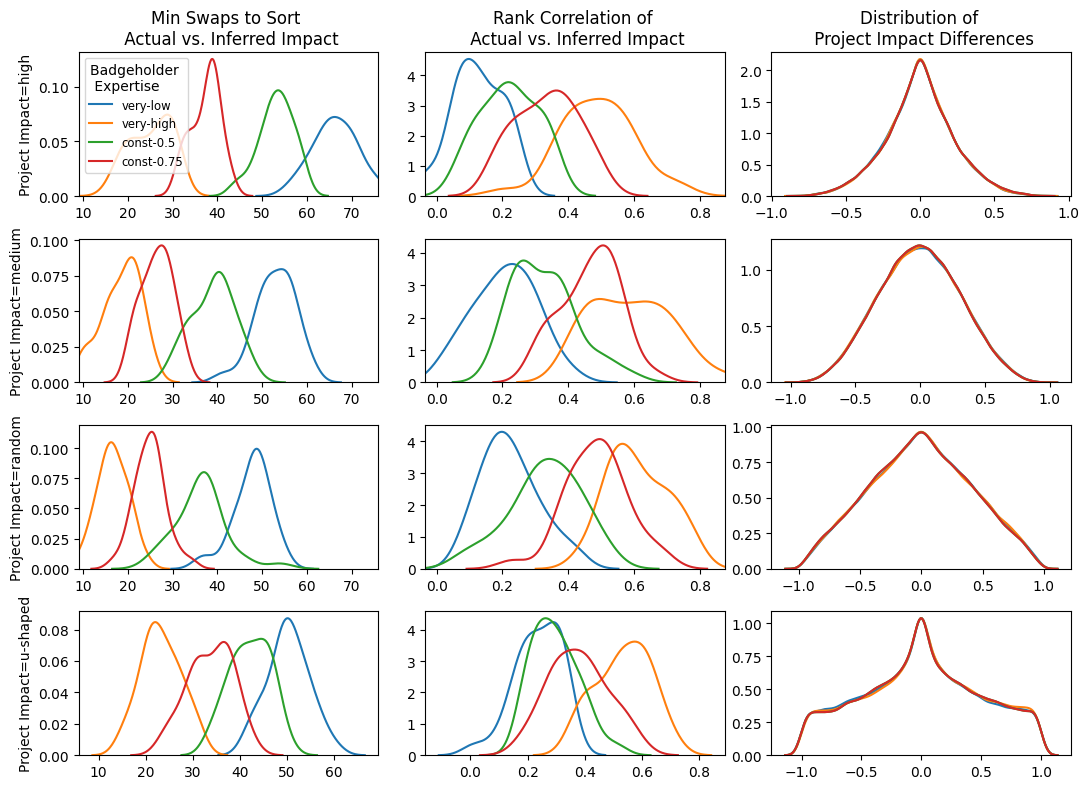

In [55]:
fig, ax = plt.subplots(4, 3, figsize=(11, 8))

min_swaps, max_swaps = np.inf, -np.inf
min_ktau, max_ktau = np.inf, -np.inf
for ii, project_impact_distribution in enumerate(project_impact_distributions):
    for jj, badgeholder_expertise_distribution in enumerate(badgeholder_expertise_distributions):
        min_swaps_vec = results_dict[project_impact_distribution][badgeholder_expertise_distribution]['min_swaps']
        ktau_vec = results_dict[project_impact_distribution][badgeholder_expertise_distribution]['ktau']
        impact_diff_vec = results_dict[project_impact_distribution][badgeholder_expertise_distribution]['impact_diff_vec']

        min_swaps = min(min_swaps, min_swaps_vec.min())
        max_swaps = max(max_swaps, min_swaps_vec.max())
        min_ktau = min(min_ktau, ktau_vec.min())
        max_ktau = max(max_ktau, ktau_vec.max())

        if ii == 0:
            l = badgeholder_expertise_distribution
        else:
            l = None
        
        sns.kdeplot(min_swaps_vec, ax=ax[ii, 0], label=l)
        sns.kdeplot(ktau_vec, ax=ax[ii, 1])
        sns.kdeplot(impact_diff_vec.flatten(), ax=ax[ii, 2])
        
        ax[ii, 0].set_ylabel(f'Project Impact={project_impact_distribution}')
        ax[ii, 1].set_ylabel(None)
        ax[ii, 2].set_ylabel(None)

        if ii == 0:
            ax[ii, 0].legend(title='Badgeholder \n Expertise', fontsize='small')
            ax[ii, 0].set_title('Min Swaps to Sort \n Actual vs. Inferred Impact')
            ax[ii, 1].set_title('Rank Correlation of \n Actual vs. Inferred Impact')
            ax[ii, 2].set_title('Distribution of \n Project Impact Differences')

for ii in range(3):
    ax[ii, 0].set_xlim([min_swaps, max_swaps])
    ax[ii, 1].set_xlim([min_ktau, max_ktau])
plt.tight_layout()

In [56]:
## assess the impact of laziness on the voting results
num_mc = 32
base_sim_cfg = {'n_badgeholders': 30, 'n_projects': 100}
project_impact_distribution = 'random'
badgeholder_expertise_distributions = ['very-low', 'very-high', 'const-0.5', 'const-0.75']
badgeholder_laziness_distributions = [ 'const-0.0', 'low', 'medium', 'high']

results_dict = {}
for badgeholder_laziness_distribution in badgeholder_laziness_distributions:
    inner_dict = {}
    for badgeholder_expertise_distribution in badgeholder_expertise_distributions:
        min_swaps_vec, ktau_vec, impact_diff_vec = run_n_simulations(
            n_sims=num_mc, 
            project_impact_distribution=project_impact_distribution,
            badgeholder_expertise_distribution=badgeholder_expertise_distribution,
            badgeholder_voting_style='skewed_towards_impact', 
            badgeholder_laziness_distribution=badgeholder_laziness_distribution,
            **base_sim_cfg
        )
        inner_dict[badgeholder_expertise_distribution] = {
            'min_swaps': min_swaps_vec, 
            'ktau': ktau_vec,
            'impact_diff_vec': impact_diff_vec
        }
    results_dict[badgeholder_laziness_distribution] = inner_dict

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

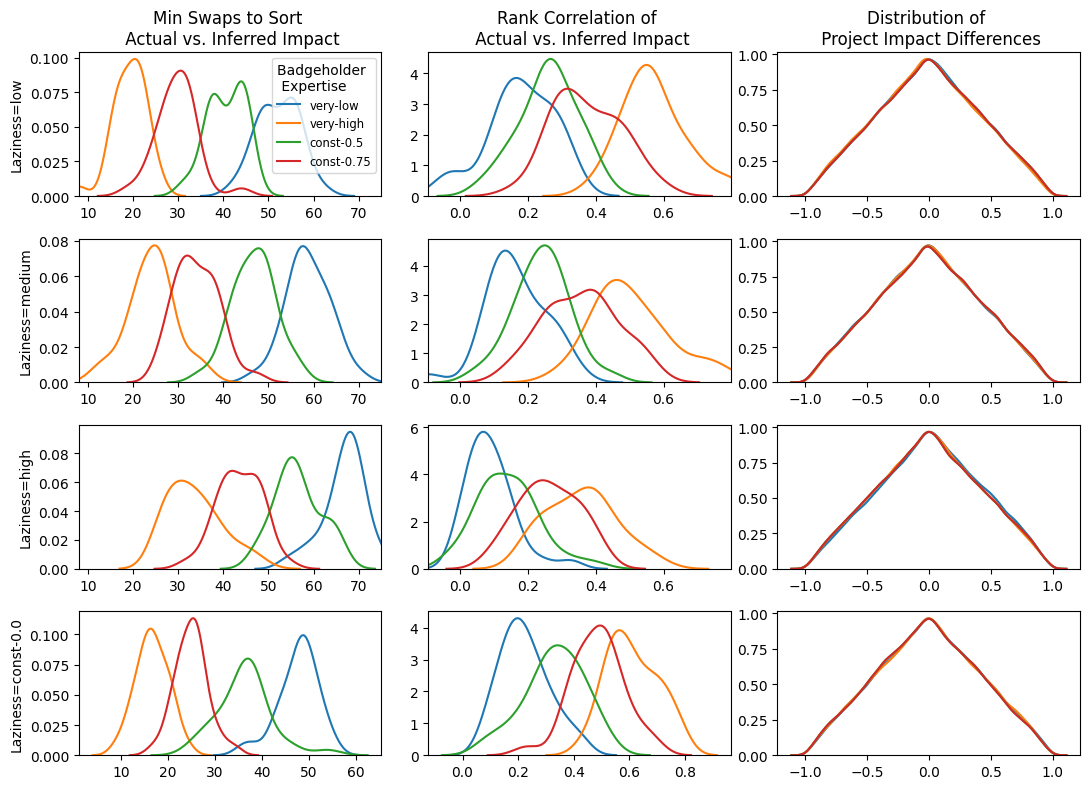

In [61]:
fig, ax = plt.subplots(4, 3, figsize=(11, 8))

min_swaps, max_swaps = np.inf, -np.inf
min_ktau, max_ktau = np.inf, -np.inf
for ii, badgeholder_laziness_distribution in enumerate(badgeholder_laziness_distributions):
    for jj, badgeholder_expertise_distribution in enumerate(badgeholder_expertise_distributions):
        # print(badgeholder_laziness_distribution, badgeholder_expertise_distribution)
        min_swaps_vec = results_dict[badgeholder_laziness_distribution][badgeholder_expertise_distribution]['min_swaps']
        ktau_vec = results_dict[badgeholder_laziness_distribution][badgeholder_expertise_distribution]['ktau']
        impact_diff_vec = results_dict[badgeholder_laziness_distribution][badgeholder_expertise_distribution]['impact_diff_vec']

        min_swaps = min(min_swaps, min_swaps_vec.min())
        max_swaps = max(max_swaps, min_swaps_vec.max())
        min_ktau = min(min_ktau, ktau_vec.min())
        max_ktau = max(max_ktau, ktau_vec.max())

        if ii == 0:
            l = badgeholder_expertise_distribution
        else:
            l = None
        
        sns.kdeplot(min_swaps_vec, ax=ax[ii, 0], label=l)
        sns.kdeplot(ktau_vec, ax=ax[ii, 1])
        sns.kdeplot(impact_diff_vec.flatten(), ax=ax[ii, 2])
        
        ax[ii, 0].set_ylabel(f'Laziness={badgeholder_laziness_distribution}')
        ax[ii, 1].set_ylabel(None)
        ax[ii, 2].set_ylabel(None)

        if ii == 0:
            ax[ii, 0].legend(title='Badgeholder \n Expertise', fontsize='small')
            ax[ii, 0].set_title('Min Swaps to Sort \n Actual vs. Inferred Impact')
            ax[ii, 1].set_title('Rank Correlation of \n Actual vs. Inferred Impact')
            ax[ii, 2].set_title('Distribution of \n Project Impact Differences')

for ii in range(3):
    ax[ii, 0].set_xlim([min_swaps, max_swaps])
    ax[ii, 1].set_xlim([min_ktau, max_ktau])
plt.tight_layout()